# _Brain Tumor Segmentation_ 

In [1]:
%matplotlib inline

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Dropout,
    Input,
    MaxPool2D,
    MaxPooling2D,
    UpSampling2D,
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence, plot_model

In [3]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices()[1], True)

![](https://mlwicf03bi27.i.optimole.com/w:842/h:738/q:mauto/f:avif/https://graylight-imaging.com/wp-content/uploads/2022/04/brain.png)

### 1. Goal

The goal is to create a U-Net model that segments breast cancer on a specific image.

### 2. Abstract

We were able to train a U-Net model that segments very closely to the actual breast cancer image. Such models provide valuable information to guide where the doctor should focus.

### _Table of Contents_
1. [Goal](#1.-Goal)
2. [Abstract](#2.-Abstract)
3. [Introduction](#3.-Introduction)
4. [Data Information](#4.-Data-Information)
5. [Data Preprocessing](#5.-Data-Preprocessing)
6. [U-Net Model](#6.-U-Net-Model)
7. [Resources](#7.-Resources)

### 3. Introduction 

A brain tumor occurs when abnormal cells grow in the brain tissue. The two main types of brain tumors are malignant (cancerous) and benign (non-cancerous). Primary tumors originate within the brain, while secondary tumors, also known as brain metastasis, often spread from diseases outside the brain. The symptoms of a brain tumor can vary widely, depending on the size and location of the tumor. Common symptoms include headaches, nausea, seizures, vision problems, and mental changes. Motor and speech difficulties, loss of sensation, and unconsciousness can also be symptoms. Magnetic Resonance Imaging (MRI) is a non-invasive method that uses a strong magnetic field to produce high-quality two-dimensional or three-dimensional images of the brain, brainstem, and cerebellum.

### 4. Data Information 

In [4]:
my_file = open("kaggle_3m/README.md", "r")
print(my_file.read())

# LGG Segmentation Dataset

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in `data.csv` file.


All images are provided in `.tif` format with 3 channels per image.
For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels).
For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing.
Missing sequences are replaced with FLAIR sequence to make all images 3-channel.
Masks are binary, 1-channel images.
They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).


The dataset is organized into 110 folders na

### 5. Data Preprocessing

Data set is from [Kaggle](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation).

In [5]:
dir = "kaggle_3m/"
mapped_data = {}
for x in os.listdir(dir):
    if "." in x:
        continue
    for y in os.listdir(os.path.join(dir, x)):
        if y.endswith("_mask.tif"):
            continue
        brain_path = os.path.join(dir, x) + "/" + os.path.join(y)
        brain_mask_path = brain_path.replace(".tif", "_mask.tif")
        mapped_data.update({brain_path: brain_mask_path})

Let's check if we have read the data correctly.

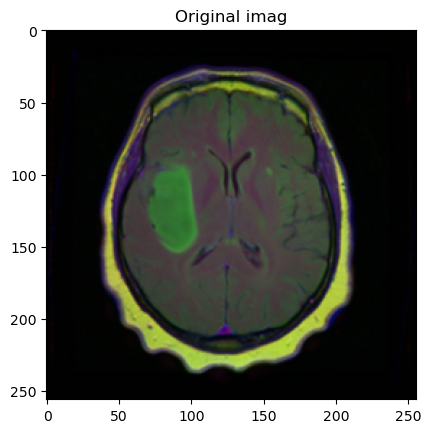

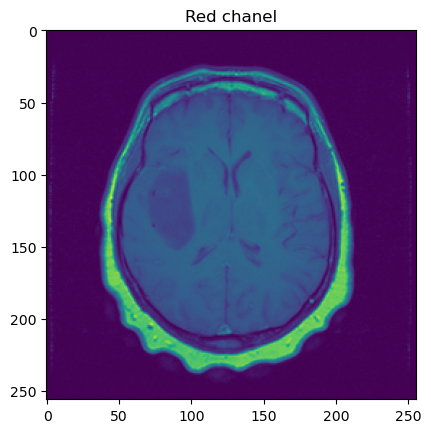

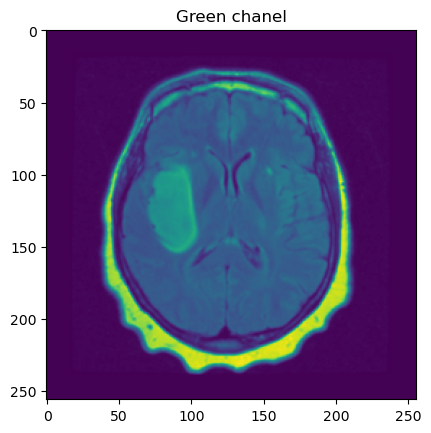

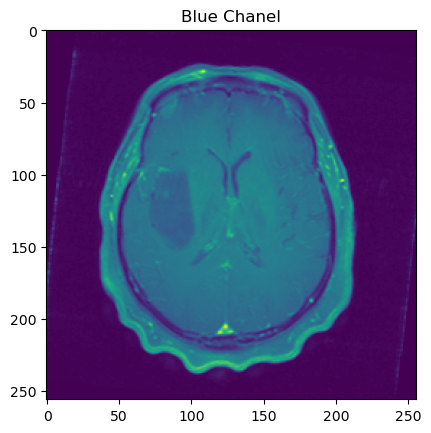

In [6]:
plt.imshow(io.imread(list(mapped_data)[25])[:, :, :])
plt.title("Original imag")
plt.show()

plt.imshow(io.imread(list(mapped_data)[25])[:, :, 0])
plt.title("Red chanel")
plt.show()

plt.imshow(io.imread(list(mapped_data)[25])[:, :, 1])
plt.title("Green chanel")
plt.show()

plt.imshow(io.imread(list(mapped_data)[25])[:, :, 2])
plt.title("Blue Chanel")
plt.show()

Each channel carries different information. You can see how the channel images differ from each other.

In [7]:
classes = [0 if np.max(io.imread(x)) == 0 else 1 for x in mapped_data.values()]

In [8]:
brain_data = pd.DataFrame(
    {
        # "pacient_id": id_patient,
        "image_of_pacient": mapped_data.keys(),
        "masks": mapped_data.values(),
        "classes": classes,
    }
)

In [9]:
brain_data = brain_data[brain_data["classes"] == 1]

We take the data that has cancer because we will not be able to segment images that do not have cancer.

In [10]:
train, val = train_test_split(brain_data, test_size=0.6, random_state=1234)

In [11]:
test, val = train_test_split(val, train_size=0.7, random_state=1234)

We split the data into training, validation, and testing sets.

In [12]:
train_ids = list(train.image_of_pacient)
train_mask = list(train.masks)

val_ids = list(val.image_of_pacient)
val_mask = list(val.masks)

We take all of the patient's paths and their cancer.

In [13]:
class Image_preprocesing(Sequence):
    def __init__(
        self,
        ids,
        mask,
        image_dir="./",
        batch_size=16,
        img_h=256,
        img_w=256,
        shuffle=True,
    ):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        list_ids = [self.ids[i] for i in indexes]
        list_mask = [self.mask[i] for i in indexes]
        X, y = self.__data_generation(list_ids, list_mask)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_ids)):
            img_path = str(list_ids[i])

            mask_path = str(list_mask[i])

            img = io.imread(img_path)
            mask = io.imread(mask_path)

            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)

            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)

            img -= img.mean()
            img /= img.std()

            mask -= mask.mean()
            mask /= mask.std()

            X[i,] = img

            y[i,] = np.expand_dims(mask, axis=2)

        y = (y > 0).astype(float)

        return X, y

We made a Sequence that reads all the images (of the patients and their cancer), determined the batch size, and prepared the images. They are now 'ready' for their training.

In [14]:
train_data = Image_preprocesing(train_ids, train_mask)
val_data = Image_preprocesing(val_ids, val_mask)

### 6. U-Net Model

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

We use the U-Net architecture for image segmentation. The U-Net model predicts every pixel in the image. It is called U-Net because its shape is in the form of a 'U'. The model consists of an encoder and a decoder. The key to this architecture is that it has skip connections that help the model learn better.

In [15]:
def resblock(X, f):
    X_copy = X

    X = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    X = Conv2D(f, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = Add()([X, X_copy])
    X = Activation("relu")(X)

    return X

In [16]:
def upsample_concat(x, skip):
    X = UpSampling2D((2, 2))(x)
    merge = Concatenate()([X, skip])

    return merge

In [17]:
X_input = Input((256, 256, 3))

conv_1 = Conv2D(
    16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
)(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(
    16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
)(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2, 2))(conv_1)

conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2, 2))(conv_2)

conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2, 2))(conv_3)

conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2, 2))(conv_4)

conv_5 = resblock(pool_4, 256)

up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

out = Conv2D(
    1, (1, 1), kernel_initializer="he_normal", padding="same", activation="sigmoid"
)(up_4)

u_net = Model(X_input, out)

In [ ]:
plot_model(u_net, show_shapes=True)

We have the model, now we just need to make the loss function and we can train it.

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred, smooth=1):
    return 1 - dice_coef(y_true, y_pred, smooth)

The Dice coefficient is defined as the ratio of the number of shared pixels (the sum of the elements in the intersection of two binary masks) to the total number of pixels in both binary masks.

In [19]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.01
)  # стандартен оптимизатор за сегментация
u_net.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

We can now train the model.

In [ ]:
trained_u_net = u_net.fit(train_data, epochs=50, validation_data=val_data)

In [ ]:
# u_net.save('u_net_model.h5')

In [ ]:
u_net_loaded = load_model(
    "u_net_model.h5",
    custom_objects={"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss},
)

In [ ]:
test_ids = list(test.image_of_pacient)
test_mask = list(test.masks)
test_data = Image_preprocesing(test_ids, test_mask)
_, acc = u_net_loaded.evaluate(test_data)
print(f"Accuracy is {acc*100:.2f}%")

In [ ]:
# model_stat=pd.Series({"loss":trained_u_net.history['loss'],
#                       'val_loss':trained_u_net.history['val_loss'],
#                       'accuracy':trained_u_net.history['dice_coef'],
#                       'val_accuracy':trained_u_net.history['val_dice_coef']
#                      })

In [ ]:
# model_stat.to_pickle("u_net_loss_and_score.pkl")

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trained_u_net.history["loss"])
plt.plot(trained_u_net.history["val_loss"])
plt.title("SEG Model dice Loss")
plt.ylabel("dice loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])

plt.subplot(1, 2, 2)
plt.plot(trained_u_net.history["dice_coef"])
plt.plot(trained_u_net.history["val_dice_coef"])
plt.title("SEG Model dice score")
plt.ylabel("Dice Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"]);

In [ ]:
def prediction_of_img(img_path):
    mask = []
    X = np.empty((1, 256, 256, 3))
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)

    # standardising the image
    img -= img.mean()
    img /= img.std()
    X[0,] = img

    predict = u_net.predict(X)

    if predict.round().astype(int).sum() == 0:
        return 'image don"t have mask'
    else:
        mask.append(predict)
    return mask

Now, we can make predictions but first we need to read it and process it.

In [ ]:
predicted_mask = (
    np.array(prediction_of_img(test.image_of_pacient[2750])).squeeze().round()
)
plt.imshow(predicted_mask)
plt.title("Predicted mask")
plt.show()
plt.imshow(io.imread(test.masks[2750]))
plt.title("Actual mask")
plt.show()
plt.imshow(io.imread(test.image_of_pacient[2750]))
plt.title("Patient brain")
plt.show()

As we can see, the model is not very good. Perhaps with a different loss function and a smaller learning rate for the Adam optimizer, and if we train for more epochs, we can achieve better results despite the fact that this model is not doing very well. (It's very close to the actual image of the hand or at least that's how I see it :D)

### 7. Resources

[Dice loss](https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras)

[References](https://www.kaggle.com/code/anantgupt/brain-mri-detection-segmentation-resunet#8:-BUILDING-A-SEGMENTATION-MODEL-TO-LOCALIZE-TUMOR)